In [1]:
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('Dataset/umist_faces.csv')


In [3]:
df.shape

(575, 10305)

In [4]:
df.head()

label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0    1a    233.0    234.0    234.0    233.0    234.0    232.0    232.0   
1    1a    234.0    234.0    234.0    234.0    233.0    232.0    202.0   
2    1a    234.0    234.0    234.0    234.0    233.0    230.0    225.0   
3    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
4    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_7  pixel_8  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    168.0     99.0  ...        157.0        154.0        151.0        147.0   
1     98.0     79.0  ...        158.0        154.0        150.0        147.0   
2    109.0     85.0  ...        180.0        174.0        168.0        164.0   
3    232.0    229.0  ...        174.0        168.0        162.0        157.0   
4    234.0    229.0  ...        186.0        176.0        170.0        164.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        143.0        140.0        141.0        141.0        140.0   
1        141.0        140.0        137.0        138.0        137.0   
2        157.0        152.0        151.0        148.0        145.0   
3        155.0        150.0        144.0        144.0        142.0   
4        162.0        157.0        152.0        150.0        148.0   

   pixel_10303  
0        136.0  
1        137.0  
2        145.0  
3        143.0  
4        148.0  

[5 rows x 10305 columns]

In [5]:
# df.duplicated()
# Custom funciton to check for duplicates
counter = 0
# If the vaues are duplicated then the label is also gonna be same
for i in range(len(df)):
    for j in range(i+1, len(df)):
        # Check for the same image if the labels are same
        if(df.iloc[i, 0] == df.iloc[j, 0]):
            # Check if the rows are same
            if(df.iloc[i, 1:].equals(df.iloc[j, 1:])):
                print("Duplicate found")
                print(df.iloc[i, 0])
                print(df.iloc[j, 0])
                print("Row 1: ", df.iloc[i, 1:])
                print("Row 2: ", df.iloc[j, 1:])
                counter += 1
                print("\n\n")
                
print("Total duplicates found: ", counter)
        

Duplicate found
1b
1b
Row 1:  pixel_0        230.0
pixel_1        230.0
pixel_2        232.0
pixel_3        230.0
pixel_4        233.0
               ...  
pixel_10299    125.0
pixel_10300    125.0
pixel_10301    125.0
pixel_10302    123.0
pixel_10303    123.0
Name: 42, Length: 10304, dtype: object
Row 2:  pixel_0        230.0
pixel_1        230.0
pixel_2        232.0
pixel_3        230.0
pixel_4        233.0
               ...  
pixel_10299    125.0
pixel_10300    125.0
pixel_10301    125.0
pixel_10302    123.0
pixel_10303    123.0
Name: 63, Length: 10304, dtype: object



Duplicate found
1b
1b
Row 1:  pixel_0        233.0
pixel_1        232.0
pixel_2        233.0
pixel_3        232.0
pixel_4        233.0
               ...  
pixel_10299    122.0
pixel_10300    125.0
pixel_10301    123.0
pixel_10302    122.0
pixel_10303    123.0
Name: 44, Length: 10304, dtype: object
Row 2:  pixel_0        233.0
pixel_1        232.0
pixel_2        233.0
pixel_3        232.0
pixel_4        233.0
      

In [6]:
# Dropping the duplicates
df = df.drop_duplicates()
df.shape

(565, 10305)

In [7]:
X = df.drop('label', axis=1).values
y = df['label']

In [8]:
# Check if there are any duplicates
df.duplicated().sum()


0

In [9]:
# Reshape images (assuming 112x92 image size)
image_size = (112, 92)
X = X.reshape(-1, *image_size)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [11]:
from sklearn.model_selection import train_test_split
# Split data into training, testing, and validation sets using stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

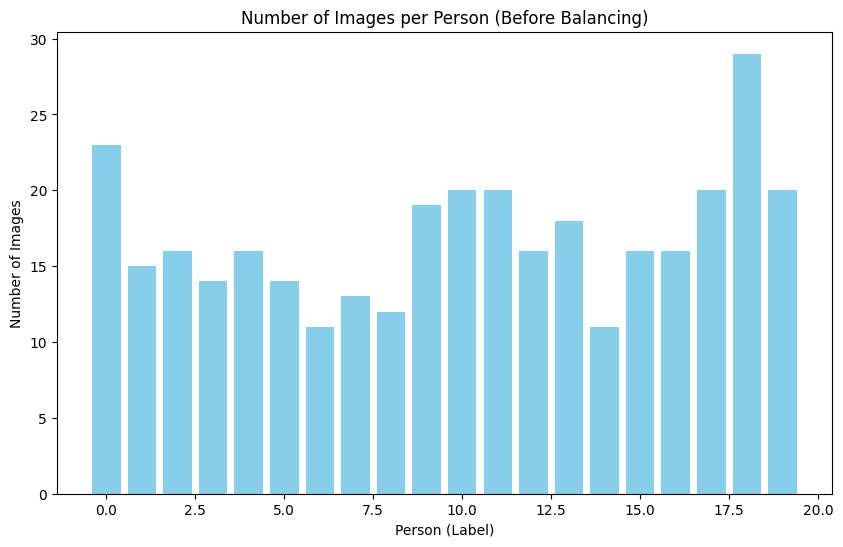

Balanced dataset shape: (960, 112, 92, 1), (960,)


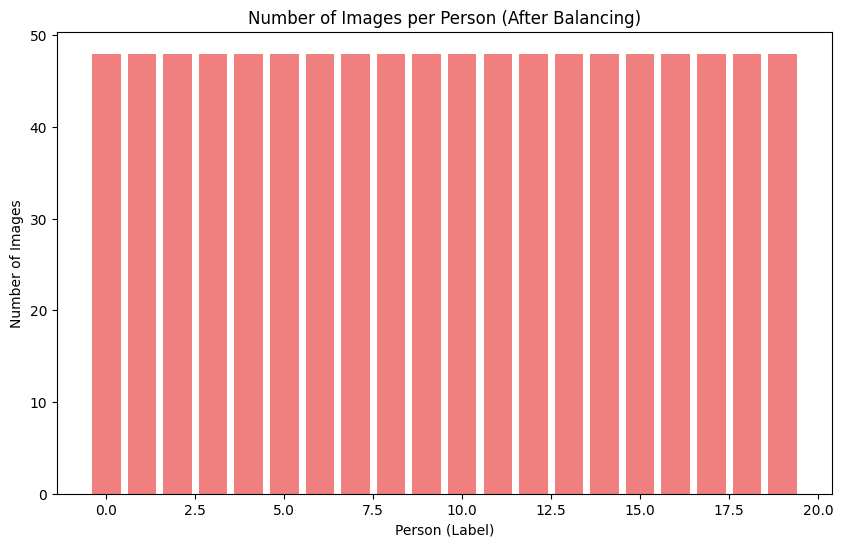

In [12]:
# Balance the training dataset using ImageDataGenerator
TARGET_IMAGES_PER_PERSON = 48

# Split the dataset by label
unique_labels = np.unique(y_train)
label_to_images = {label: X_train[y_train == label] for label in unique_labels}

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Before balancing: plot the number of images per person
initial_counts = [np.sum(y_train == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, initial_counts, color='skyblue')
plt.title('Number of Images per Person (Before Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

balanced_X = []
balanced_y = []

for label, images in label_to_images.items():
    num_images = images.shape[0]
    if num_images < TARGET_IMAGES_PER_PERSON:
        # Add channel dimension to images (assuming grayscale images)
        images = np.expand_dims(images, axis=-1)  # Shape becomes (num_images, height, width, 1)
        
        # Generate augmented images
        augmented_images = []
        for x in datagen.flow(images, batch_size=1, seed=42):
            augmented_images.append(x[0])  # x is a batch, take the first image
            if len(augmented_images) + num_images >= TARGET_IMAGES_PER_PERSON:
                break
        combined_images = np.concatenate([images, np.array(augmented_images)])
    else:
        # Randomly select TARGET_IMAGES_PER_PERSON images
        combined_images = images[np.random.choice(num_images, TARGET_IMAGES_PER_PERSON, replace=False)]

    balanced_X.extend(combined_images)
    balanced_y.extend([label] * TARGET_IMAGES_PER_PERSON)

# Convert balanced dataset to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Balanced dataset shape: {balanced_X.shape}, {balanced_y.shape}")

# After balancing: plot the number of images per person
balanced_counts = [np.sum(balanced_y == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, balanced_counts, color='lightcoral')
plt.title('Number of Images per Person (After Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

// Preprocessing Steps

In [13]:
X_train = balanced_X.reshape(balanced_X.shape[0], -1)
y_train = balanced_y

In [14]:
X_train

array([[234.        , 235.        , 234.        , ..., 190.        ,
        191.        , 190.        ],
       [234.        , 234.        , 234.        , ..., 191.        ,
        192.        , 193.        ],
       [234.        , 234.        , 234.        , ..., 166.        ,
        164.        , 163.        ],
       ...,
       [ 83.10621643,  83.42729187,  83.74836731, ...,  82.85794067,
         76.26061249,  63.9704628 ],
       [ 40.28157425,  40.62338638,  40.9651947 , ...,  62.30971909,
         63.98275375,  70.80506134],
       [164.        , 164.        , 164.        , ...,  42.46702957,
         38.42023468,  41.31652832]])

In [15]:
# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [16]:
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [17]:
# PCA

# Perform PCA on the training set
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

X_train_pca.shape

(960, 140)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense

def create_model(n_hidden_layer_1, n_bottleneck, n_hidden_layer_2, learning_rate, regularizer):
    model = models.Sequential()
    model.add(Input(shape=(140,)))
    model.add(Dense(n_hidden_layer_1, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(regularizer)))
    model.add(Dense(n_bottleneck, activation='leaky_relu'))
    model.add(Dense(n_hidden_layer_2, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(regularizer)))
    model.add(Dense(140, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

In [19]:
# Hyperparameters
n_hidden_layer_1 = [108, 64]
n_bottleneck = [64, 32]
n_hidden_layer_2 = [108, 64]
learning_rates = [0.001, 0.01]
regularizers = [1e-4]

# Grid search
# K-fold cross-validation
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
best_score = 0
best_params = None

for n_units_1 in n_hidden_layer_1:
    for n_bottleneck_units in n_bottleneck:
        for n_units_2 in n_hidden_layer_2:
            for lr in learning_rates:
                for reg in regularizers:
                    fold_scores = []
                    for train_index, val_index in kf.split(X_train_pca):
                        X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
                        y_train_fold, y_val_fold = X_train_pca[train_index], X_train_pca[val_index]  # Autoencoder uses input as output
                        
                        model = create_model(n_units_1, n_bottleneck_units, n_units_2, lr, reg)
                        model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0)
                        score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
                        fold_scores.append(score)  # Loss
                        
                    avg_score = np.mean(fold_scores)
                    if avg_score < best_score or best_score == 0:  # Lower loss is better
                        best_score = avg_score
                        best_params = {'n_units_1': n_units_1, 'n_bottleneck': n_bottleneck_units, 'n_units_2': n_units_2, 'learning_rate': lr, 'regularizer': reg}

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Loss: {best_score}")


Best Hyperparameters: {'n_units_1': 108, 'n_bottleneck': 64, 'n_units_2': 108, 'learning_rate': 0.001, 'regularizer': 0.0001}
Best Cross-Validation Loss: 2.1336057662963865


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


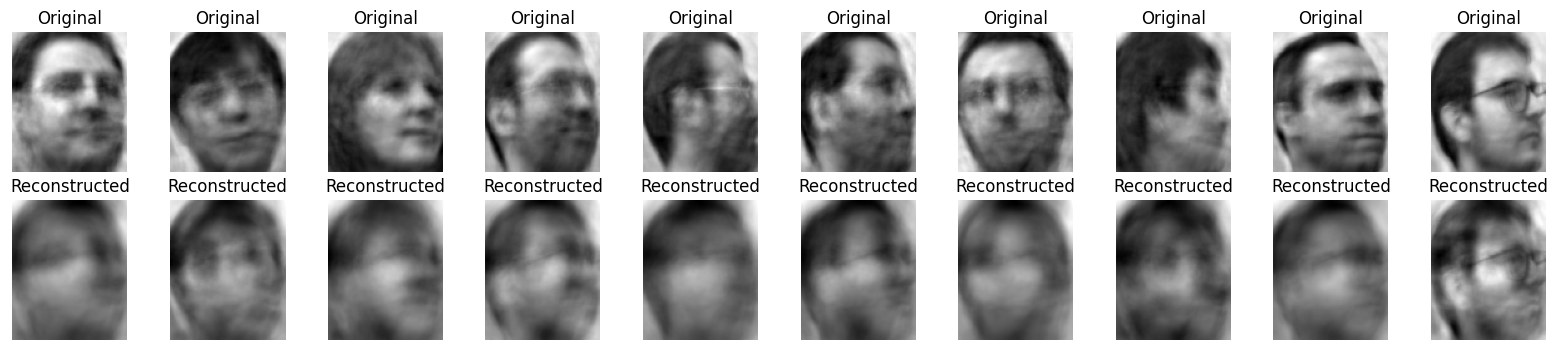

In [20]:
import matplotlib.pyplot as plt
# Create an autoencoder with the best hyperparameters
best_model = create_model(best_params['n_units_1'], best_params['n_bottleneck'], best_params['n_units_2'], best_params['learning_rate'], best_params['regularizer'])
history = best_model.fit(X_train_pca, X_train_pca, epochs=30, batch_size=32, verbose=0)

def plot_reconstruction(autoencoder, X_test_pca, n=10):
    decoded_imgs = autoencoder.predict(X_test_pca)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(pca.inverse_transform(X_test_pca[i]).reshape(112, 92), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Display reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(pca.inverse_transform(decoded_imgs[i]).reshape(112, 92), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Visualize reconstruction on the test set
plot_reconstruction(best_model, X_test_pca)

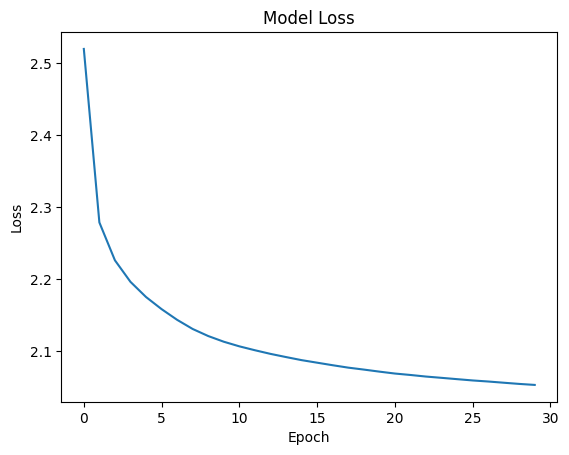

In [21]:
# Plottin the loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
    

In [22]:
X_train_encoded = best_model.predict(X_train_pca)
X_valid_encoded = best_model.predict(X_val_pca)
X_test_encoded = best_model.predict(X_test_pca)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [23]:
# Normalize the encoded data
X_train_encoded = X_train_encoded / np.max(X_train_encoded)
X_valid_encoded = X_valid_encoded / np.max(X_valid_encoded)
X_test_encoded = X_test_encoded / np.max(X_test_encoded)


In [24]:
X_train_encoded.shape

(960, 140)

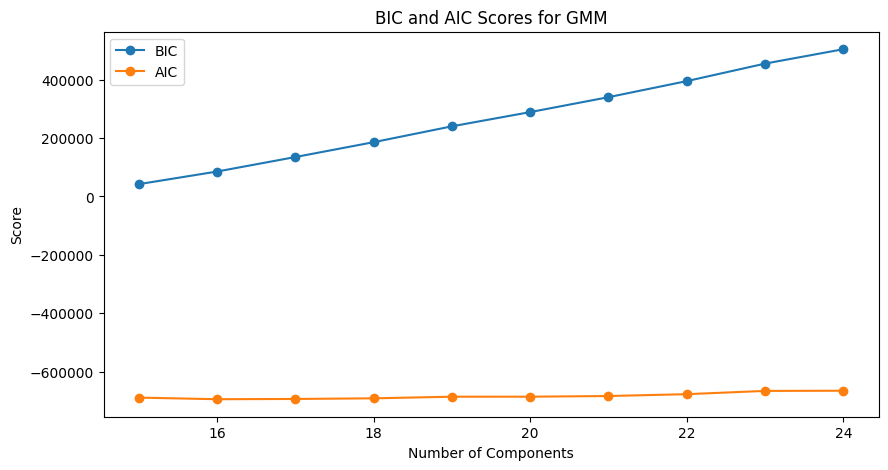

Optimal number of components based on AIC: 16


In [25]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

bic_scores = []
aic_scores = []

n_components_range = range(15, 25)  # Range for number of clusters

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_train_encoded)
    
    # Record BIC and AIC scores
    bic_scores.append(gmm.bic(X_train_encoded))
    aic_scores.append(gmm.aic(X_train_encoded))

# Plot BIC and AIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()
plt.title('BIC and AIC Scores for GMM')
plt.show()

# Select the optimal number of components with the lowest BIC
best_n_components_aic = n_components_range[aic_scores.index(min(aic_scores))]
print(f"Optimal number of components based on AIC: {best_n_components_aic}")


In [26]:
gmm = GaussianMixture(n_components=best_n_components_aic, random_state=0)
y_gmm = gmm.fit_predict(X_train_encoded)

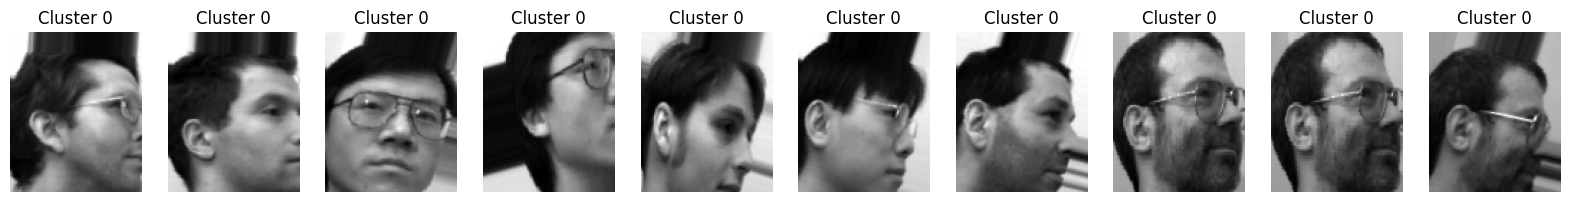

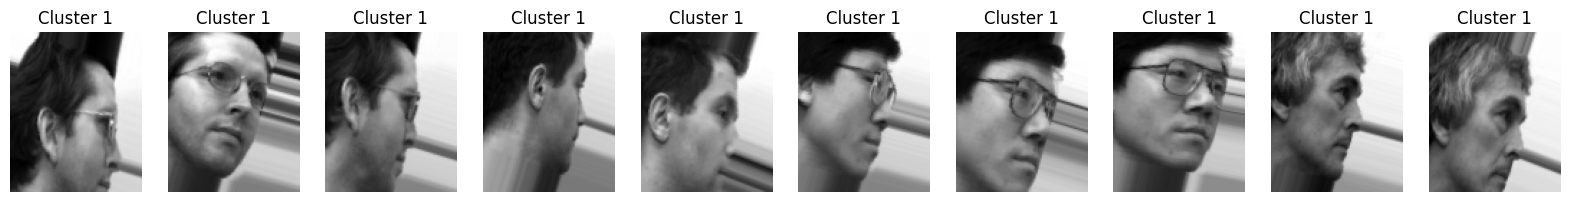

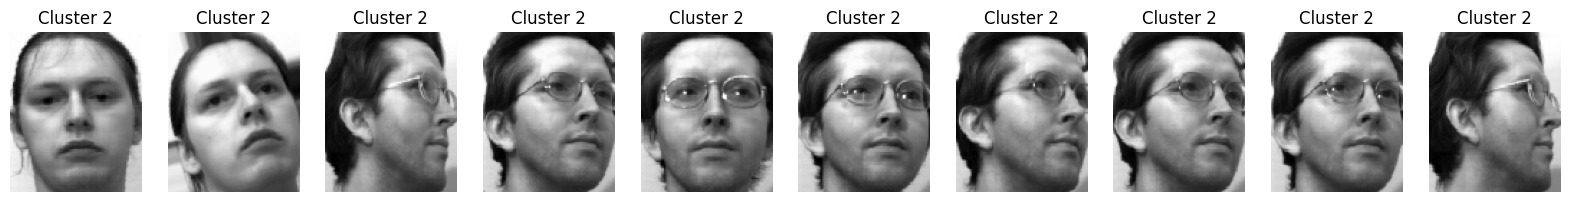

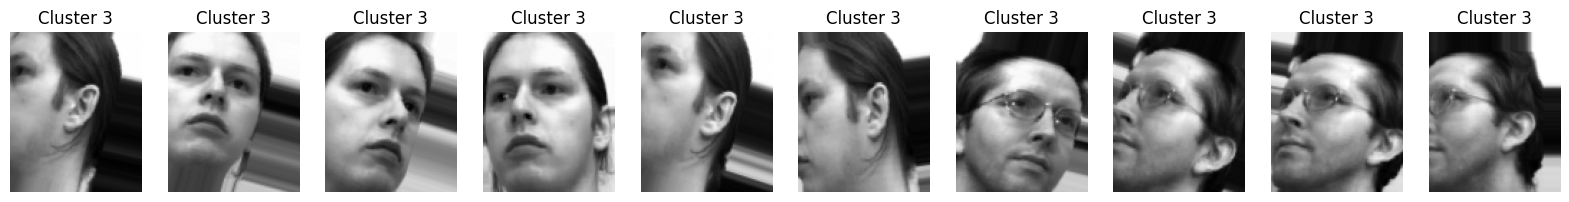

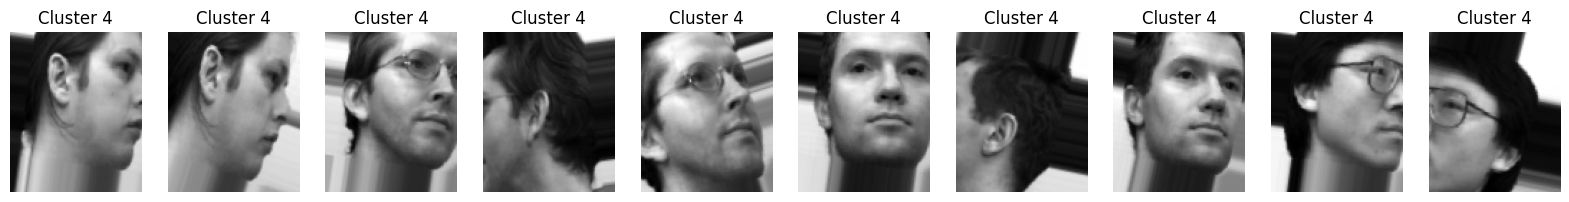

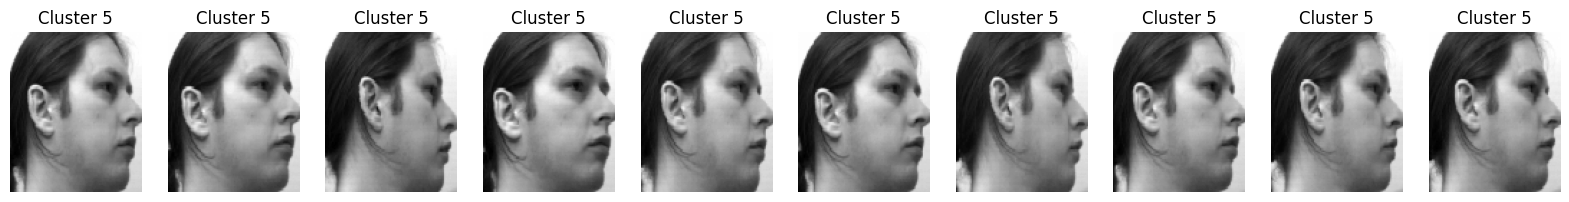

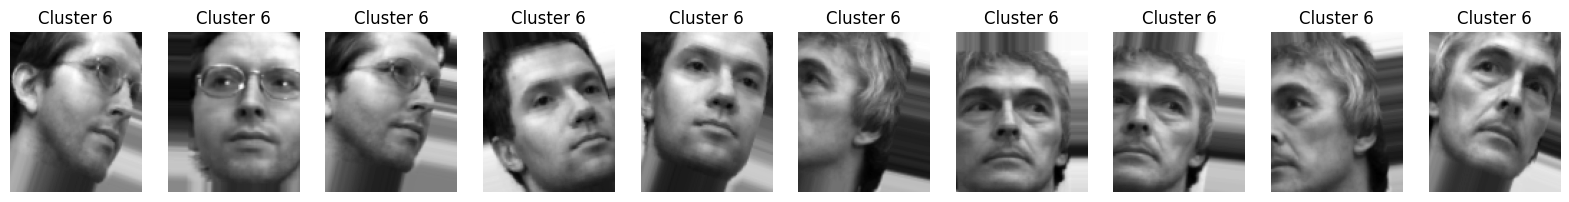

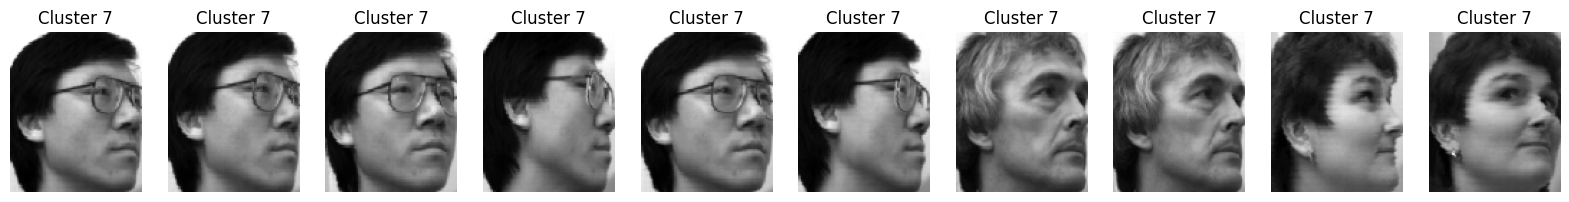

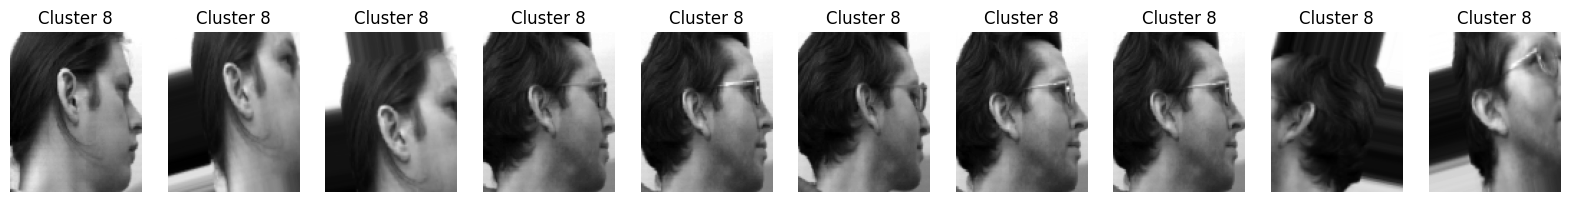

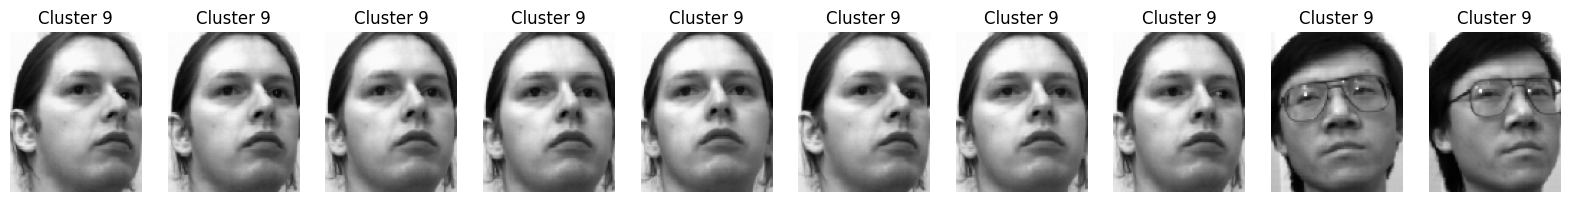

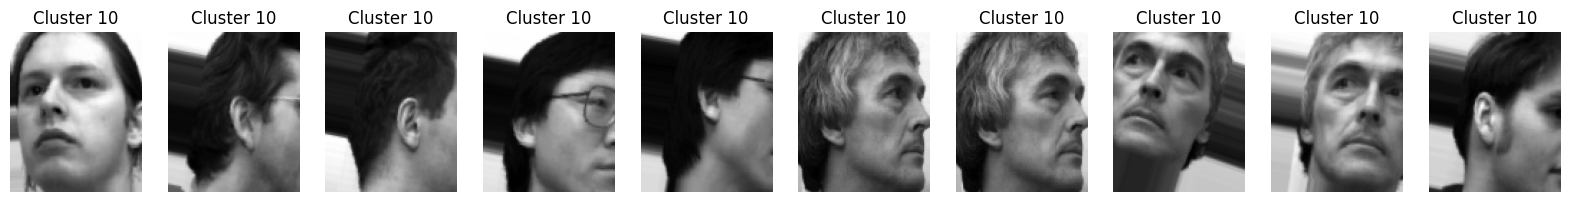

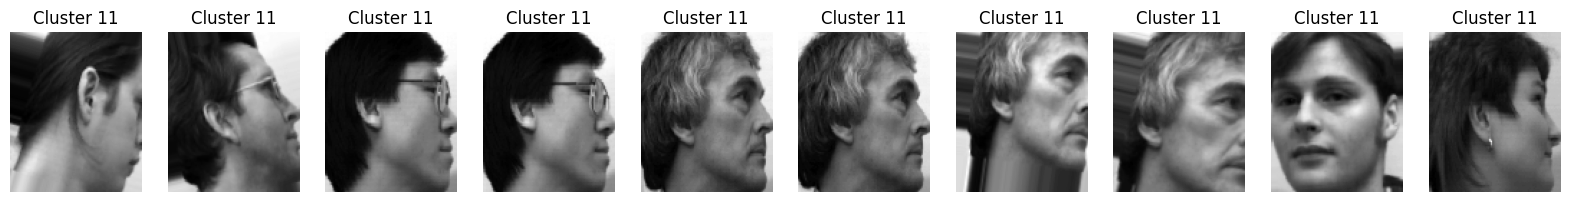

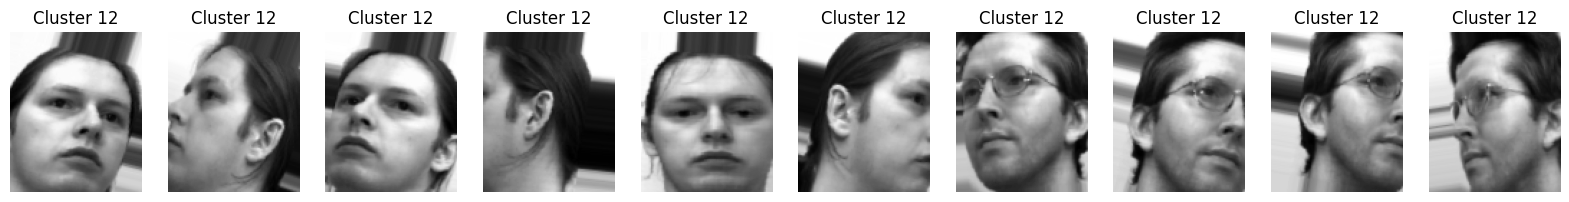

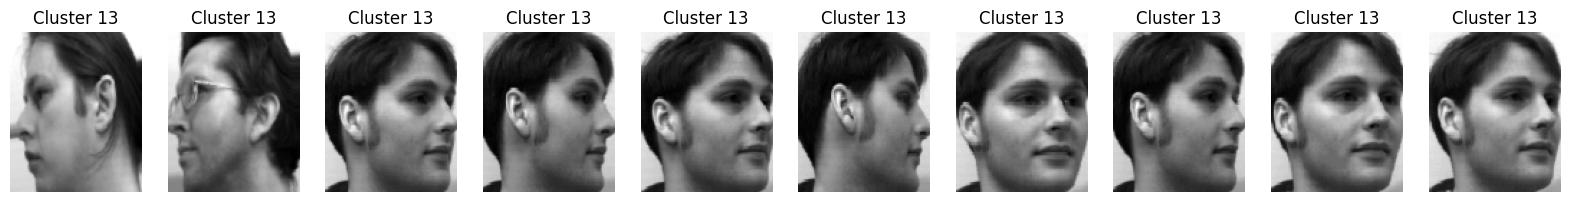

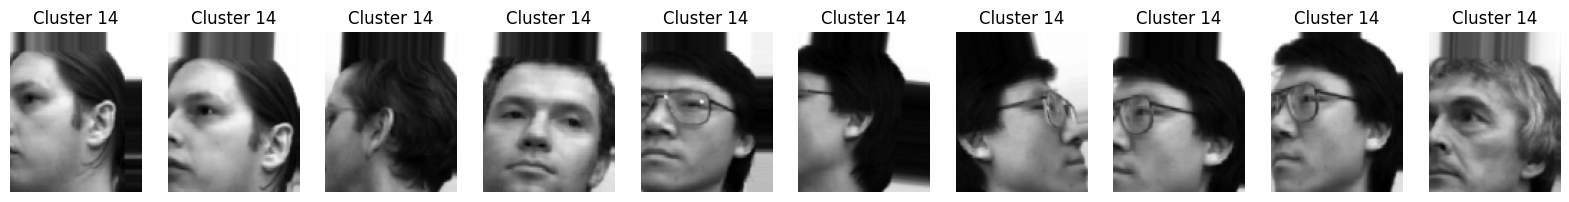

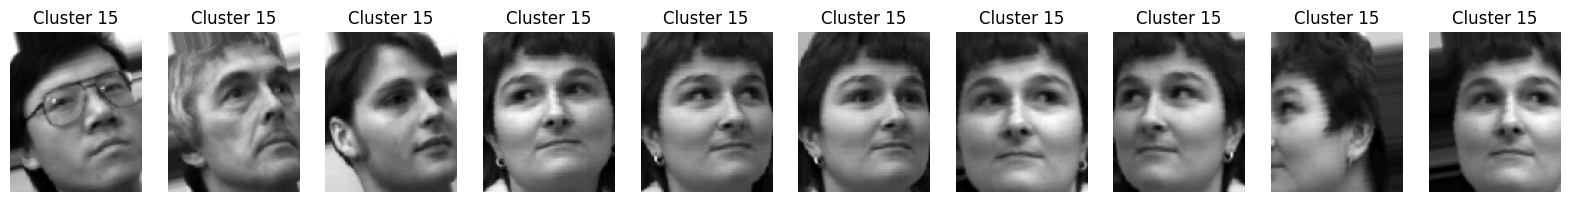

In [27]:
# Vizuallize the clusters by plotting the images of the cluster members

def plot_cluster(cluster_id, X, y, n=10):
    cluster_indices = np.where(y == cluster_id)[0]
    n = min(n, len(cluster_indices))
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow((X_train[cluster_indices[i]]).reshape(112, 92), cmap='gray')
        plt.title(f"Cluster {cluster_id}")
        plt.axis("off")
    plt.show()

# Plot the first 10 images in each cluster
for cluster_id in range(best_n_components_aic):
    plot_cluster(cluster_id, X_train_encoded, y_gmm)



In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical



num_clusters = len(np.unique(y_gmm))  
clusters_one_hot = to_categorical(y_gmm, num_clusters)
X_train_augmented = np.hstack((X_train_encoded, clusters_one_hot))
X_val_clusters = to_categorical(gmm.predict(X_valid_encoded), num_clusters)
X_val_augmented = np.hstack((X_valid_encoded, X_val_clusters))
X_test_clusters = to_categorical(gmm.predict(X_test_encoded), num_clusters)
X_test_augmented = np.hstack((X_test_encoded, X_test_clusters))


In [29]:
# One-hot encode labels for classification
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [30]:
from tensorflow.keras import layers, regularizers, Sequential, optimizers

input_shape = X_train_augmented.shape[1]
# Build the model
model = Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.1),
    layers.Dense(y_train_one_hot.shape[1], activation='softmax')  # Changed to softmax
])


model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),  
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

history = model.fit(
    X_train_augmented, y_train_one_hot,
    validation_data=(X_val_augmented, y_val_one_hot),
    epochs=100,
    batch_size=50  )


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0631 - loss: 3.2425 - val_accuracy: 0.0885 - val_loss: 3.1579
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0791 - loss: 3.1812 - val_accuracy: 0.1681 - val_loss: 3.0813
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1385 - loss: 3.1134 - val_accuracy: 0.3009 - val_loss: 2.9968
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1798 - loss: 3.0434 - val_accuracy: 0.3805 - val_loss: 2.8964
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2569 - loss: 2.9712 - val_accuracy: 0.3894 - val_loss: 2.7836
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2989 - loss: 2.8760 - val_accuracy: 0.5487 - val_loss: 2.6303
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3313 - loss: 2.7757 - val_accuracy: 0.5487 - val_loss: 2.4693
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3510 - loss: 2.6633 - val_accuracy: 0.6372 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.9121 - loss: 0.6474  
Test Loss: 0.643726646900177
Test Accuracy: 0.9026548862457275


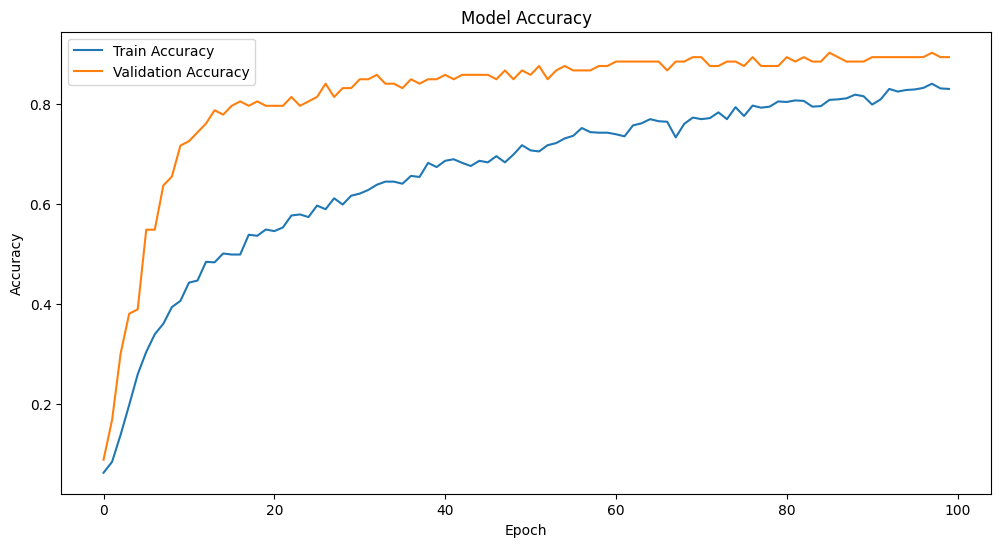

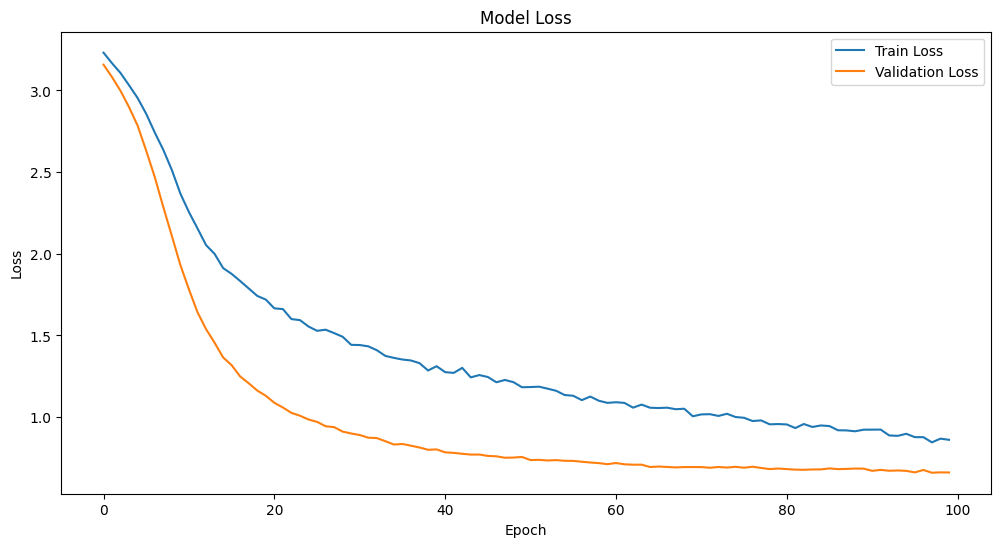

In [31]:

results = model.evaluate(X_test_augmented, y_test_one_hot)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


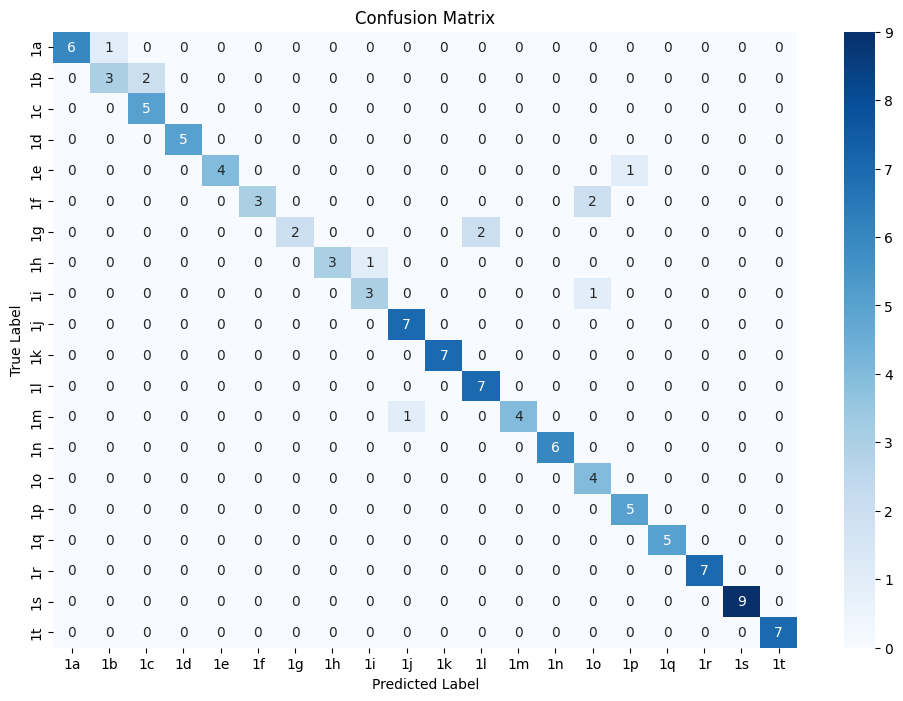

In [32]:

y_pred = model.predict(X_test_augmented)
y_pred = np.argmax(y_pred, axis=1)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


TypeError: 'int' object is not subscriptable

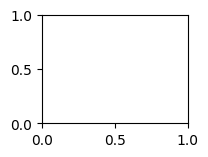

In [38]:
random_index = range(1,10)

for i in range(9):
    random_image = X_test[random_index[i]]
    random_image = random_image.reshape(1, -1)
    random_image_pca = pca.transform(random_image)
    random_image_cluster = gmm.predict(random_image_pca)
    random_image_cluster_one_hot = to_categorical(random_image_cluster, num_clusters)
    random_image_augmented = np.hstack((random_image_pca, random_image_cluster_one_hot))
    prediction = model.predict(random_image_augmented)
    predicted_label = np.argmax(prediction)
    actual_label = y_test[random_index[i]]
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[random_index[i]].reshape(112, 92), cmap='gray')
    plt.title(f'Actual: {le.inverse_transform([actual_label])[0]}\nPredicted: {le.inverse_transform([predicted_label])[0]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

